## Explaning the reasons for which Machine can Go into Downtime With CatBoost Machine Learning and SHAPLY Values

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyodbc as odbc
import plotly.express as px
import warnings
import duckdb as db
import dtale as dtl2
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from datetime import datetime, date, time
import re

# pd.set_option('display.max_rows',1200)
# pd.set_option('display.max_columns',100)
#!pip install catboost
#!pip install shap

### Building a Classifier Model and see how much each feature impacts the downtime.  Basically if Past information of the machine can predict whether a downtime will occur or not. What features has been used and how they have been dervied has been explained below.

**Read Data**

In [11]:
syteline_summ3 = pd.read_csv('explaning_downtime_core_file.csv')

In [12]:
syteline_summ3 = syteline_summ3[['Timestamp', 'CardSize', 'TotalCards', 'GoodCards',
       'RejectedCards', 'FeedSpeed', 'Job', 'TransactionType',
       'TransactionDate', 'Completed', 'TotalHours', 'Employee',
       'StartDateTime', 'EndDateTime', 'UserInitials','Temperature_fahrenheit','ReltiveHumidity_rh']]

syteline_summ3.Timestamp = pd.to_datetime(syteline_summ3.Timestamp)
syteline_summ3.StartDateTime = pd.to_datetime(syteline_summ3.StartDateTime)
syteline_summ3.EndDateTime = pd.to_datetime(syteline_summ3.EndDateTime)

print(syteline_summ3.shape)
syteline_summ3.head(5)

(41662, 17)


Timestamp  CardSize  TotalCards  GoodCards  RejectedCards  \
0 2023-04-10 09:40:58       NaN           0          0              0   
1 2023-04-10 09:41:58       NaN           0          0              0   
2 2023-04-10 09:42:58       NaN           0          0              0   
3 2023-04-10 09:43:58       NaN           0          0              0   
4 2023-04-10 09:44:58       NaN           0          0              0   

   FeedSpeed  Job TransactionType TransactionDate  Completed  TotalHours  \
0        0.0  NaN             NaN             NaN        NaN         NaN   
1        0.0  NaN             NaN             NaN        NaN         NaN   
2        0.0  NaN             NaN             NaN        NaN         NaN   
3        0.0  NaN             NaN             NaN        NaN         NaN   
4        0.0  NaN             NaN             NaN        NaN         NaN   

   Employee StartDateTime EndDateTime UserInitials  Temperature_fahrenheit  \
0       NaN           NaT         NaT          NaN               69.900002   
1       NaN           NaT         NaT          NaN               69.900002   
2       NaN           NaT         NaT          NaN               69.900002   
3       NaN           NaT         NaT          NaN               69.900002   
4       NaN           NaT         NaT          NaN               69.900002   

   ReltiveHumidity_rh  
0           42.700001  
1           42.700001  
2           42.700001  
3           42.700001  
4           42.700001

#### Calculating Downtimes and Flagging accordingly
Information regarding Downtime is Not logged in the ERP. Therefore need to come up with a method that can flag a state as Downtime. <br>
Data is logged irrespective of Machine is running or not. Thus in order to calculate Downtime, we consider only when Transaction Type is Run. That is when an Operator would have ran the machine. The above dataframe is already engineered in a Database which looks into ERP and Machine data and Log based on overlap times.<br> 
I read and try to find the Downtime by checking whenever there is no cards produced consecutively for more than 15 mins or so.

In [13]:
from itertools import groupby

syteline_summ3_run = syteline_summ3.query("TransactionType == 'Run'")

templist = syteline_summ3_run['TotalCards'].to_list()

list_1 = []
list_2 = []
for i, group in groupby(templist):
    list_1.append(list(group))
for i in list_1:
    z = len(i)
    list_2.append([z]*z)
    
list_final = [item for sublist in list_2 for item in sublist]
syteline_summ3_run['ConsecutiveFrequcnyCount'] = list_final

In [14]:
#dtl2.show(syteline_summ3_run).open_browser()

In [15]:
syteline_summ3_run['idx'] = syteline_summ3_run.index
syteline_summ3_run = \
db.sql("SELECT *, \
       CASE WHEN TotalCards = 0 THEN \
           CASE WHEN ConsecutiveFrequcnyCount>0 AND ConsecutiveFrequcnyCount<=5 THEN 'Full Run'\
                WHEN ConsecutiveFrequcnyCount>5 AND ConsecutiveFrequcnyCount<=15 THEN 'Hiccup'\
                WHEN ConsecutiveFrequcnyCount>15 THEN 'Downtime' END\
       ELSE 'Full Run' END AS Downtime_Ind_New\
       FROM syteline_summ3_run").df()

syteline_summ3_run.set_index('idx',inplace=True)

#updating in the main table
syteline_summ3.loc[syteline_summ3.TransactionType=='Run','Downtime_Ind_New'] = syteline_summ3_run['Downtime_Ind_New']

syteline_summ3.loc[syteline_summ3.TransactionType=='Setup','Downtime_Ind_New'] = 'Setup'

In [16]:
#dtl2.show(syteline_summ3).open_browser()

Getting The Feqeuncy of Values in the DownTimeInd Column. This will help to filter out noisy data in the following steps.<br>
We are going to flag the column of Downtime indicator for when the machine is under setup, when it is running but not logged, when there is a downtime or a hiccup state i.e. the machine is not producing cards even though it is running.

With thorough analysis of the data, certain assumptions were made to properly flag the Downtime Indicator column.<br>
**The calculation of the downtime indicator column is critical as it ultimately becomes our Target Label.**

In [17]:
syteline_summ3_copy = syteline_summ3.copy()

syteline_summ3_copy.loc[(syteline_summ3_copy.Downtime_Ind_New.isnull()) & (syteline_summ3_copy.TotalCards>0),\
                        'Downtime_Ind_New'] = 'RunWOClock'

templist = syteline_summ3_copy['Downtime_Ind_New'].to_list()

list_1 = []
list_2 = []
for i, group in groupby(templist):
    list_1.append(list(group))
for i in list_1:
    z = len(i)
    list_2.append([z]*z)
    
list_final = [item for sublist in list_2 for item in sublist]
syteline_summ3_copy['DowntimeFrequcnyCount'] = list_final

In [18]:
#dtl2.show(syteline_summ3_copy).open_browser()

In [19]:
syteline_summ3_copy.loc[(syteline_summ3_copy.Downtime_Ind_New.isnull()) & (syteline_summ3_copy.DowntimeFrequcnyCount>=5) \
                        & (syteline_summ3_copy.TransactionType.isnull()), \
                       'Downtime_Ind_New'] = 'No Run'

syteline_summ3_copy.loc[syteline_summ3_copy.DowntimeFrequcnyCount==1,'Downtime_Ind_New'] = np.nan
                        
syteline_summ3_copy.loc[(syteline_summ3_copy.DowntimeFrequcnyCount>1) & (syteline_summ3_copy.DowntimeFrequcnyCount<=3)\
                        & (syteline_summ3_copy.Downtime_Ind_New!='Full Run'),\
                        'Downtime_Ind_New'] = np.nan


#take another copy of the data to filter and fix further
syteline_summ3_copy2 = syteline_summ3_copy.copy()
syteline_summ3_copy2 = syteline_summ3_copy2[~syteline_summ3_copy2.Downtime_Ind_New.isnull()]
syteline_summ3_copy2.TransactionType.fillna('NA',inplace=True)

There are many cases when there is a big gap between machine runs. In order to figure that ou calculating the time difference of each data point from next data point. Ideally it should be 1 min.

In [20]:
#take another copy of the data to do feature calculations and everything else
syteline_summ3_copy3 = syteline_summ3_copy2.copy()

syteline_summ3_copy3 = syteline_summ3_copy3[['Timestamp', 'CardSize', 'TotalCards', 'GoodCards', 'RejectedCards',
       'FeedSpeed', 'UserInitials', 'Temperature_fahrenheit', 'ReltiveHumidity_rh',
       'Downtime_Ind_New', 'DowntimeFrequcnyCount']]

syteline_summ3_copy3['NexTimestamp'] = syteline_summ3_copy3.Timestamp.shift(-1)

syteline_summ3_copy3['TimeDiff_NowToNext'] = \
                        (syteline_summ3_copy3.NexTimestamp - syteline_summ3_copy3.Timestamp).dt.total_seconds()

In [21]:
#dtl2.show(syteline_summ3_copy2).open_browser() #.kill()
syteline_summ3_copy3.head()

Timestamp  CardSize  TotalCards  GoodCards  RejectedCards  \
0 2023-04-10 09:40:58       NaN           0          0              0   
1 2023-04-10 09:41:58       NaN           0          0              0   
2 2023-04-10 09:42:58       NaN           0          0              0   
3 2023-04-10 09:43:58       NaN           0          0              0   
4 2023-04-10 09:44:58       NaN           0          0              0   

   FeedSpeed UserInitials  Temperature_fahrenheit  ReltiveHumidity_rh  \
0        0.0          NaN               69.900002           42.700001   
1        0.0          NaN               69.900002           42.700001   
2        0.0          NaN               69.900002           42.700001   
3        0.0          NaN               69.900002           42.700001   
4        0.0          NaN               69.900002           42.700001   

  Downtime_Ind_New  DowntimeFrequcnyCount        NexTimestamp  \
0           No Run                    244 2023-04-10 09:41:58   
1           No Run                    244 2023-04-10 09:42:58   
2           No Run                    244 2023-04-10 09:43:58   
3           No Run                    244 2023-04-10 09:44:58   
4           No Run                    244 2023-04-10 09:45:58   

   TimeDiff_NowToNext  
0                60.0  
1                60.0  
2                60.0  
3                60.0  
4                60.0

**Before Filtering out any noisy data, it is important to add the new features in the dataframe. In this case the explainable features are decided to be what is happening in the last 30 mins. The idea is to calculate if what is happening in the last 30 mins can inform what is going to happen next. That is wether the machine will Run or go into a Downtime. And with that information Find out which features contributed the most towards the Downtime.**

In [22]:
syteline_summ3_copy3 = \
db.sql("SELECT *,\
        (SELECT stddev_samp(TotalCards) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 30 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp) TotalCards_Var_Last30,\
        (SELECT sum(TotalCards) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 30 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp) TotalCards_Sum_Last30,\
        (SELECT avg(TotalCards) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 30 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp) TotalCards_Mean_Last30,\
        (SELECT stddev_samp(RejectedCards) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 30 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp) RejectedCards_Var_Last30,\
        (SELECT sum(RejectedCards) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 30 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp) RejectedCards_Sum_Last30,\
        (SELECT avg(RejectedCards) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 30 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp) RejectedCards_Mean_Last30,\
        (SELECT stddev_samp(FeedSpeed) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 30 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp) FeedSpeed_Var_Last30,\
        (SELECT avg(FeedSpeed) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 30 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp) FeedSpeed_Mean_Last30,\
        (SELECT avg(Temperature_fahrenheit) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 120 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp - INTERVAL 60 MINUTES) Temp_Mean_Last1hr,\
        (SELECT avg(ReltiveHumidity_rh) FROM syteline_summ3_copy3 subtab \
                WHERE subtab.Timestamp>= maintab.Timestamp - INTERVAL 120 MINUTES \
                    AND subtab.Timestamp<= maintab.Timestamp - INTERVAL 60 MINUTES) Humdty_Mean_Last1hr\
        FROM syteline_summ3_copy3 maintab").df()

syteline_summ3_copy3['DayofWeek'] = syteline_summ3_copy3.Timestamp.dt.dayofweek+1
syteline_summ3_copy3['HourofDay'] = syteline_summ3_copy3['Timestamp'].dt.hour

syteline_summ3_copy3['Shift'] = np.where(((syteline_summ3_copy3.HourofDay>=7) & (syteline_summ3_copy3.HourofDay<15)),0,\
                                np.where(((syteline_summ3_copy3.HourofDay>=15) & (syteline_summ3_copy3.HourofDay<23)),1,\
                                np.where((syteline_summ3_copy3.HourofDay>=23),2,2)))

syteline_summ3_copy3 = syteline_summ3_copy3.sort_values(by='Timestamp')
print(syteline_summ3_copy3.shape)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(41218, 26)


In [23]:
#dtl2.show(syteline_summ3_copy3).open_browser()

We need to filter out the unnecessary data that can confuse the model. We only want to keep information related to consecutive time points as we are looking for data in last 30 mins (for cards, rejected cards etc) or last 60 mins(for environmental data).
<br>
While removing Setup/No Run data removes the unnecessary information.<br>
Also removing, Last1hour temp data which are NAN removes many cases when consecutive timestamps are not available.<br>

We also need to remove all those cases where User Initials are not available. Those cases are occuring when Machine is running without a clock.

In [32]:
syteline_summ3_copy4 = syteline_summ3_copy3.copy()

#1 Remove No Run Cases and Setup Transaction Cases
syteline_summ3_copy4 = syteline_summ3_copy4.query('Downtime_Ind_New not in ("Setup","No Run")')

#2 Remove cases where last 30 min data is nan
syteline_summ3_copy4 =  syteline_summ3_copy4.dropna(subset=['RejectedCards_Var_Last30'])
syteline_summ3_copy4 =  syteline_summ3_copy4.dropna(subset=['TotalCards_Var_Last30'])
syteline_summ3_copy4 =  syteline_summ3_copy4.dropna(subset=['Temp_Mean_Last1hr'])
syteline_summ3_copy4 =  syteline_summ3_copy4.dropna(subset=['UserInitials'])

#If Downtime then 1 Else 0
syteline_summ3_copy4['TargetVar'] =  np.where(syteline_summ3_copy4.Downtime_Ind_New=="Downtime",1,0)
print(syteline_summ3_copy4.shape)
syteline_summ3_copy4.head()

(29463, 27)


Timestamp  CardSize  TotalCards  GoodCards  RejectedCards  \
358 2023-04-10 15:38:01       2.0         508        408            100   
359 2023-04-10 15:39:01       NaN         502        400            102   
360 2023-04-10 15:40:01       NaN           0          0              0   
361 2023-04-10 15:41:01       2.0           0        -70             70   
362 2023-04-10 15:42:01       2.0         272        204             68   

     FeedSpeed UserInitials  Temperature_fahrenheit  ReltiveHumidity_rh  \
358     99.775          JT1               70.800003           44.099998   
359     98.686          JT1               70.800003           44.099998   
360     27.356          JT1               70.800003           44.099998   
361     26.825          JT1               70.800003           44.099998   
362     99.775          JT1               70.800003           44.099998   

    Downtime_Ind_New  DowntimeFrequcnyCount        NexTimestamp  \
358         Full Run                     17 2023-04-10 15:39:01   
359         Full Run                     17 2023-04-10 15:40:01   
360         Full Run                     17 2023-04-10 15:41:01   
361         Full Run                     17 2023-04-10 15:42:01   
362         Full Run                     17 2023-04-10 15:43:01   

     TimeDiff_NowToNext  TotalCards_Var_Last30  TotalCards_Sum_Last30  \
358                60.0             188.023477                 4098.0   
359                60.0             197.630746                 4600.0   
360                60.0             197.630746                 4600.0   
361                60.0             197.630746                 4600.0   
362                60.0             196.859696                 4872.0   

     TotalCards_Mean_Last30  RejectedCards_Var_Last30  \
358              132.193548                 38.634544   
359              148.387097                 40.064411   
360              148.387097                 40.064411   
361              148.387097                 39.934570   
362              157.161290                 39.623931   

     RejectedCards_Sum_Last30  RejectedCards_Mean_Last30  \
358                    1017.0                  32.806452   
359                    1119.0                  36.096774   
360                    1119.0                  36.096774   
361                    1189.0                  38.354839   
362                    1257.0                  40.548387   

     FeedSpeed_Var_Last30  FeedSpeed_Mean_Last30  Temp_Mean_Last1hr  \
358             42.496866              73.048871          71.280326   
359             42.433614              72.953194          71.272130   
360             41.130339              73.835645          71.263933   
361             39.785353              74.700968          71.255736   
362             37.511586              77.919516          71.247539   

     Humdty_Mean_Last1hr  DayofWeek  HourofDay  Shift  TargetVar  
358            40.027868          1         15      1          0  
359            40.031147          1         15      1          0  
360            40.034426          1         15      1          0  
361            40.037704          1         15      1          0  
362            40.040983          1         15      1          0

In [33]:
#dtl2.show(syteline_summ3_copy4).open_browser() 

Creating another copy of the data to perform Machine Learning. Splitting the data into X and Y.

In [34]:
syteline_summ3_copy5 = syteline_summ3_copy4.copy()

syteline_summ3_copy5 = syteline_summ3_copy5[['Timestamp','FeedSpeed', 'UserInitials', 'Temperature_fahrenheit',
                                             'ReltiveHumidity_rh','NexTimestamp', 'TimeDiff_NowToNext', 'TotalCards_Var_Last30',
                                             'TotalCards_Sum_Last30', 'TotalCards_Mean_Last30','RejectedCards_Var_Last30', 
                                             'RejectedCards_Sum_Last30','RejectedCards_Mean_Last30', 'FeedSpeed_Var_Last30',
                                             'FeedSpeed_Mean_Last30', 'Temp_Mean_Last1hr', 'Humdty_Mean_Last1hr',
                                             'DayofWeek', 'HourofDay', 'Shift', 'TargetVar']]

X = syteline_summ3_copy5[['UserInitials', 'Temperature_fahrenheit','ReltiveHumidity_rh', 'TotalCards_Var_Last30',
                                             'TotalCards_Sum_Last30', 'TotalCards_Mean_Last30','RejectedCards_Var_Last30', 
                                             'RejectedCards_Sum_Last30','RejectedCards_Mean_Last30', 'FeedSpeed_Var_Last30',
                                             'FeedSpeed_Mean_Last30', 'Temp_Mean_Last1hr', 'Humdty_Mean_Last1hr',
                                             'DayofWeek', 'HourofDay', 'Shift']] #'TimeDiff_NowToNext'
y = syteline_summ3_copy5[['TargetVar']]

#dtl2.show(syteline_summ3_copy5).open_browser()

Douing  stratified sampling so that Categorical variables remain same in both train test samples. Also verified that similar percentage of classes are there both in train and test dataset.

In [35]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, log_loss, roc_auc_score
from sklearn.metrics import accuracy_score,confusion_matrix


X_train, X_test, y_train, y_test = \
            train_test_split(X,y, test_size=0.3, stratify=X['UserInitials'], random_state=42, shuffle=True)

In [36]:
X.head()

UserInitials  Temperature_fahrenheit  ReltiveHumidity_rh  \
358          JT1               70.800003           44.099998   
359          JT1               70.800003           44.099998   
360          JT1               70.800003           44.099998   
361          JT1               70.800003           44.099998   
362          JT1               70.800003           44.099998   

     TotalCards_Var_Last30  TotalCards_Sum_Last30  TotalCards_Mean_Last30  \
358             188.023477                 4098.0              132.193548   
359             197.630746                 4600.0              148.387097   
360             197.630746                 4600.0              148.387097   
361             197.630746                 4600.0              148.387097   
362             196.859696                 4872.0              157.161290   

     RejectedCards_Var_Last30  RejectedCards_Sum_Last30  \
358                 38.634544                    1017.0   
359                 40.064411                    1119.0   
360                 40.064411                    1119.0   
361                 39.934570                    1189.0   
362                 39.623931                    1257.0   

     RejectedCards_Mean_Last30  FeedSpeed_Var_Last30  FeedSpeed_Mean_Last30  \
358                  32.806452             42.496866              73.048871   
359                  36.096774             42.433614              72.953194   
360                  36.096774             41.130339              73.835645   
361                  38.354839             39.785353              74.700968   
362                  40.548387             37.511586              77.919516   

     Temp_Mean_Last1hr  Humdty_Mean_Last1hr  DayofWeek  HourofDay  Shift  
358          71.280326            40.027868          1         15      1  
359          71.272130            40.031147          1         15      1  
360          71.263933            40.034426          1         15      1  
361          71.255736            40.037704          1         15      1  
362          71.247539            40.040983          1         15      1

Performing One Hot Encoding to update Categorical Features to Numerical

In [38]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train.head()

Temperature_fahrenheit  ReltiveHumidity_rh  TotalCards_Var_Last30  \
39973               70.000000           54.099998               0.000000   
24418               70.500000           44.099998              84.464410   
3598                70.900002           41.700001             197.547408   
4963                70.900002           38.500000              95.766450   
5114                70.400002           41.000000              15.309636   

       TotalCards_Sum_Last30  TotalCards_Mean_Last30  \
39973                    0.0                0.000000   
24418                 8359.0              269.645161   
3598                  3174.0              102.387097   
4963                  1528.0               49.290323   
5114                   204.0                6.580645   

       RejectedCards_Var_Last30  RejectedCards_Sum_Last30  \
39973                  0.000000                       0.0   
24418                 25.348708                    2136.0   
3598                  26.860092                     457.0   
4963                  37.408871                     524.0   
5114                   8.427681                     103.0   

       RejectedCards_Mean_Last30  FeedSpeed_Var_Last30  FeedSpeed_Mean_Last30  \
39973                   0.000000              0.000000               0.000000   
24418                  68.903226             29.943503              89.971903   
3598                   14.741935             43.621733              27.398161   
4963                   16.903226             46.349271              34.258484   
5114                    3.322581             33.166885              18.213161   

       Temp_Mean_Last1hr  Humdty_Mean_Last1hr  DayofWeek  HourofDay  Shift  \
39973          70.400002            52.318333          6          3      2   
24418          70.470000            42.780000          3         12      0   
3598           70.206780            43.364406          3         22      1   
4963           70.880001            37.686667          4         22      1   
5114           70.715000            39.425000          5          0      2   

       UserInitials_AH1  UserInitials_CB1  UserInitials_DJ1  UserInitials_JT1  \
39973                 0                 0                 0                 0   
24418                 0                 1                 0                 0   
3598                  0                 0                 0                 1   
4963                  0                 0                 0                 1   
5114                  0                 0                 0                 1   

       UserInitials_MB1  UserInitials_MB2  UserInitials_NG1  UserInitials_PS1  \
39973                 0                 0                 1                 0   
24418                 0                 0                 0                 0   
3598                  0                 0                 0                 0   
4963                  0                 0                 0                 0   
5114                  0                 0                 0                 0   

       UserInitials_RJ2  UserInitials_SM3  UserInitials_TP1  
39973                 0                 0                 0  
24418                 0                 0                 0  
3598                  0                 0                 0  
4963                  0                 0                 0  
5114                  0                 0                 0

**Running the Cat Boost Algorithm. In this project, there wasn't enough time to work with multiple types of Models and find out which model provides the best result. Catboost was selected because it can handle categorical features (although I have one hot encoded them, but during experiemntation I didn't)<br>
Performance of the model was tracked mainly through ROC Curve. Hyperparameters are selected based on trial and error method (No Hyperparameter tuning ws performed due to time constraints)**

In [30]:
cat_clf = CatBoostClassifier(
    iterations=1000, 
    depth=12,
    learning_rate=0.05,
    verbose=200,
    eval_metric='AUC',
    od_type='Iter',
    od_wait=500
)


cat_clf.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.9270880	best: 0.9270880 (0)	total: 341ms	remaining: 5m 40s
200:	test: 0.9980475	best: 0.9980475 (200)	total: 24.7s	remaining: 1m 38s
400:	test: 0.9988082	best: 0.9988088 (399)	total: 48.8s	remaining: 1m 12s
600:	test: 0.9989766	best: 0.9989766 (600)	total: 1m 13s	remaining: 48.9s
800:	test: 0.9990354	best: 0.9990362 (797)	total: 1m 37s	remaining: 24.2s
999:	test: 0.9990554	best: 0.9990573 (967)	total: 2m 2s	remaining: 0us

bestTest = 0.9990572797
bestIteration = 967

Shrink model to first 968 iterations.


**Model Performs Fine and predicts with 98% accuracy**

In [39]:
pred_test = cat_clf.predict(X_test)
test_score = accuracy_score(y_test,pred_test)
print("Test score:", test_score)

Test score: 0.9881208281479805


In [45]:
X_test['predicted_val'] = pred_test

#dtl2.show(X_test).open_browser()

**Confusion Matrix**

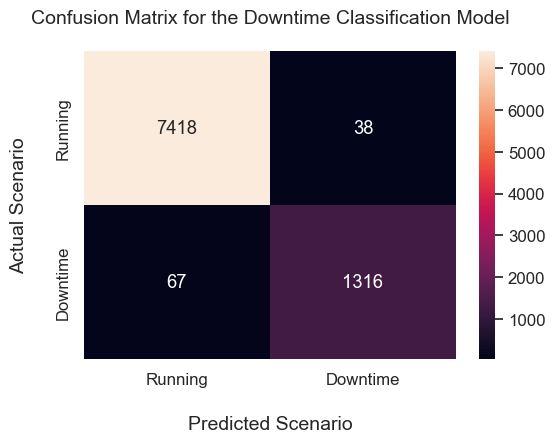

In [40]:
plt.figure(figsize=(6,4), dpi=100)
sns.set(font_scale = 1.1)

ax = sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt='d', )

ax.set_xlabel("Predicted Scenario", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Running', 'Downtime'])

ax.set_ylabel("Actual Scenario", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Running', 'Downtime'])

ax.set_title("Confusion Matrix for the Downtime Classification Model", fontsize=14, pad=20)

plt.show()

### Now Using SHAP to get Feature Importance. The idea is to find out which features contrbuted most towards the downtime.<br>
**What values of the features were important and if any range need to be maintained.<br>
Also deep dive and see for Individual if there was any particular feature that was more important than other which contributed towards a downtime.**

In [41]:
import shap

shap.initjs()
explainer = shap.Explainer(cat_clf) 
shap_values = explainer(X_train)

#shap_values_testing = shap_values

Defining Feature Importance funnction below where we take the mean of the absolute shap values for all different features. This features can be normalized with softmax method as it ensures output values lie between 0 and 1 and adds upto 1. This was we can know which feature's probability was maximum. 

In [42]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    importances = []
    
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    
    importances_norm = softmax(importances)
    
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    #     for k, v in feature_importances.items():
    #         print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
    #plt.barh(*zip(*feature_importances.items()))
    #plt.show()
    
    feature_importances_df = pd.DataFrame.from_dict(feature_importances,orient='index', columns=['vals']).reset_index()
    sns.barplot(data=feature_importances_df.sort_values(by='vals', ascending=False), x='vals', y='index', orient='h')
    plt.yticks(fontsize=8)

### Now we look at Feature Importance over all data space. 

From the following graph, we can identify that in the last 30 minutes, variance in Feed Speed (or speed at machine was runnning), variance in the number of rejected products (number of of products getting rejected varied to much), mean humidity in the previous hour, hour of the day has been the most important features for the model.<br>
We now would like to know, what values of this model affected the model output.

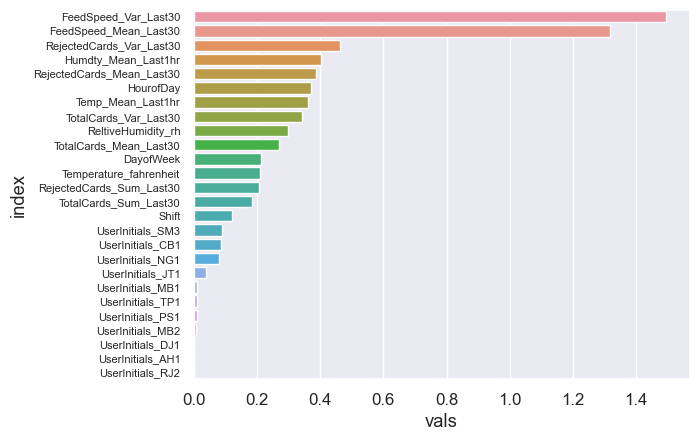

In [43]:
print_feature_importances_shap_values(shap_values,X_train.columns)

The below summary plot of Shapley helps us understand what values of the features drived the model towards a downtime. The features has been arranged by decending order of importance. In our data, downtime has been denoted as 1 whereas if the machine is running we are denoting as 0.<br>

Lets look at individual cases:<br>
- when the feature value of the variance of Feed Speed (i.e. machine operating speed) is in the last 30 mins is red (that is very high) the model is more likely to predict a downtime. Similarly if that operating speed mean is low (that is in the last 30 mins it is operating at a low speed) then machine is likely to predict a downtime.
- rejected cards variance in the last 30 mins also indicate that a high value can cause the model to preidct a downtime.
- Humidity values are not very discernable in the following plot. But we can feel that there is a range that is working. We will use a force plot to understand more.
- The hour of the day seems little random and we may need to look deeper into that feature.
- Temperature if it is very less in the last hour can cause the model more likely to predict a downtime. This means temeprature value should be high. Force plot/Scatter Plot can tell us better about the scenario.
- We can also notice that when there oeprators such as SM3, JT1 the model is more likely to predict downtime.

<br>
With all this analysis it will be helpful to the management to dig deeper in such cases, validate the results and improve the process wherever necessary.

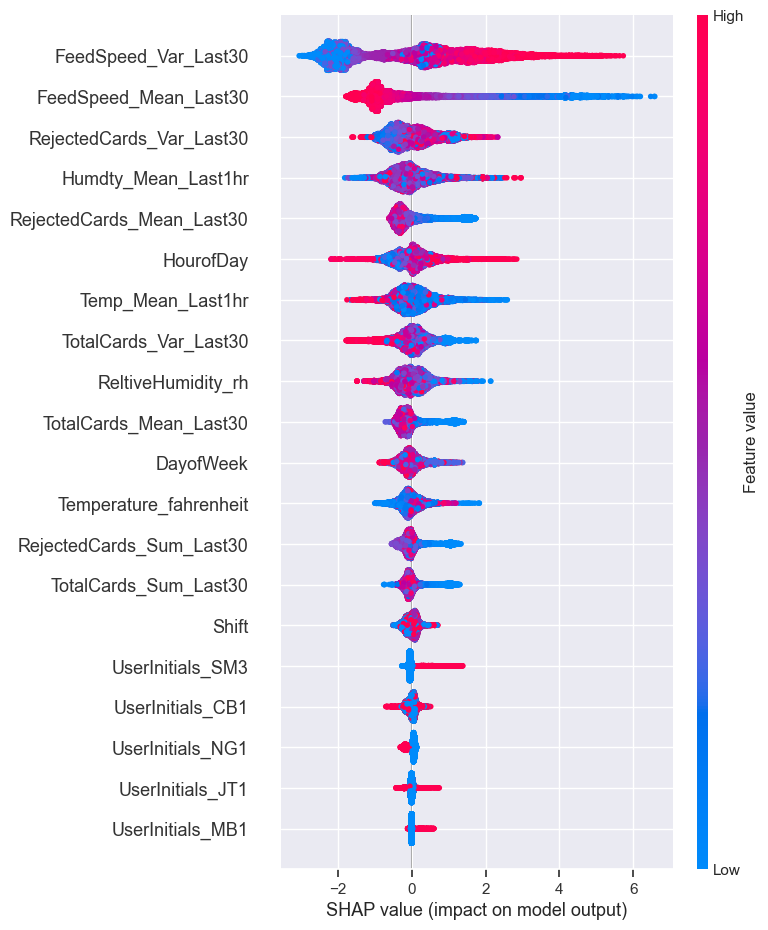

In [26]:
shap.summary_plot(shap_values, X_train)

By using the below scatter plots, we can look into individual values of the features that is causing the model to predict a certain value. Values below 0 (y-axis) means model is more likely to predict machine will run. Data points above 0 (y-axis) will indicate it is more likely to predict machine will go into a downtime. 
<br>
- In the below image we can see there is a darker cloud below 0 for Rejected cards  variancce in the last 30 mins when the variance is low. That indicates less likely the model will predict that machine will go into a downtime.

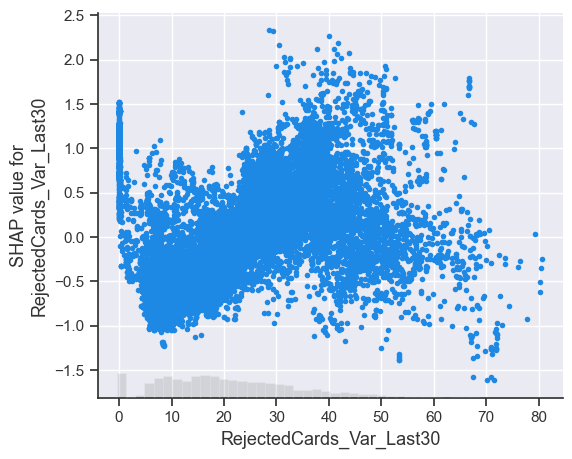

In [46]:
#shap.plots.scatter(shap_values[:, 'HourofDay' ]) 
#shap.plots.scatter(shap_values[:, 'DayofWeek' ])
shap.plots.scatter(shap_values[:, 'RejectedCards_Var_Last30' ])

- Similarly in the below plot we can see that withing the range of 40-45 humidity level in the previous hour there is a darker cloud towards lesser than 0 Shap values. Shap values increase more it is not within this range thus cuasing the model to predict downtime. This information will be more visible when we individually look at different jobs.

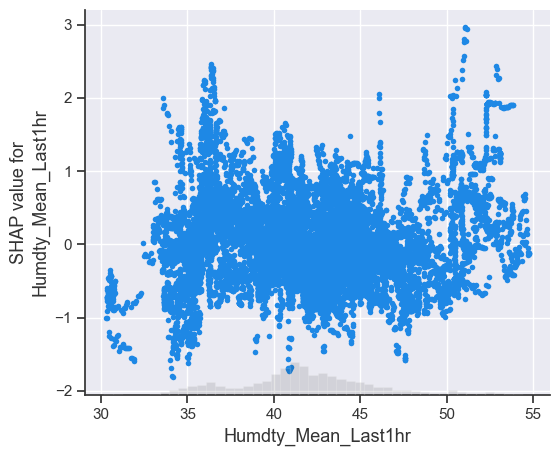

In [55]:
shap.plots.scatter(shap_values[:, 'Humdty_Mean_Last1hr' ])

In [56]:
#X_train.HourofDay.value_counts()
#X_train[['RejectedCards_Var_Last30','RejectedCards_Sum_Last30','TotalCards_Var_Last30','TotalCards_Sum_Last30']].corr()

### Preparing the dataset to identify data points for individual jobs, so that we can use the SHAP values and look at individual batch of jobs and identify what happened.

In [48]:
X_train_copy=X_train.copy()
X_train_copy['array_idx'] = range(0,len(X_train))
X_train_copy.head()

Temperature_fahrenheit  ReltiveHumidity_rh  TotalCards_Var_Last30  \
39973               70.000000           54.099998               0.000000   
24418               70.500000           44.099998              84.464410   
3598                70.900002           41.700001             197.547408   
4963                70.900002           38.500000              95.766450   
5114                70.400002           41.000000              15.309636   

       TotalCards_Sum_Last30  TotalCards_Mean_Last30  \
39973                    0.0                0.000000   
24418                 8359.0              269.645161   
3598                  3174.0              102.387097   
4963                  1528.0               49.290323   
5114                   204.0                6.580645   

       RejectedCards_Var_Last30  RejectedCards_Sum_Last30  \
39973                  0.000000                       0.0   
24418                 25.348708                    2136.0   
3598                  26.860092                     457.0   
4963                  37.408871                     524.0   
5114                   8.427681                     103.0   

       RejectedCards_Mean_Last30  FeedSpeed_Var_Last30  FeedSpeed_Mean_Last30  \
39973                   0.000000              0.000000               0.000000   
24418                  68.903226             29.943503              89.971903   
3598                   14.741935             43.621733              27.398161   
4963                   16.903226             46.349271              34.258484   
5114                    3.322581             33.166885              18.213161   

       Temp_Mean_Last1hr  Humdty_Mean_Last1hr  DayofWeek  HourofDay  Shift  \
39973          70.400002            52.318333          6          3      2   
24418          70.470000            42.780000          3         12      0   
3598           70.206780            43.364406          3         22      1   
4963           70.880001            37.686667          4         22      1   
5114           70.715000            39.425000          5          0      2   

       UserInitials_AH1  UserInitials_CB1  UserInitials_DJ1  UserInitials_JT1  \
39973                 0                 0                 0                 0   
24418                 0                 1                 0                 0   
3598                  0                 0                 0                 1   
4963                  0                 0                 0                 1   
5114                  0                 0                 0                 1   

       UserInitials_MB1  UserInitials_MB2  UserInitials_NG1  UserInitials_PS1  \
39973                 0                 0                 1                 0   
24418                 0                 0                 0                 0   
3598                  0                 0                 0                 0   
4963                  0                 0                 0                 0   
5114                  0                 0                 0                 0   

       UserInitials_RJ2  UserInitials_SM3  UserInitials_TP1  array_idx  
39973                 0                 0                 0          0  
24418                 0                 0                 0          1  
3598                  0                 0                 0          2  
4963                  0                 0                 0          3  
5114                  0                 0                 0          4

In [49]:
filter_per_Xtrain = syteline_summ3_copy5.loc[X_train.index,:]
print(filter_per_Xtrain.shape)
filter_per_Xtrain.head()

(20624, 21)


Timestamp  FeedSpeed UserInitials  Temperature_fahrenheit  \
39973 2023-06-03 03:10:59      0.000          NG1               70.000000   
24418 2023-05-03 12:53:57     99.024          CB1               70.500000   
3598  2023-04-12 22:30:27    100.114          JT1               70.900002   
4963  2023-04-13 22:04:39     97.523          JT1               70.900002   
5114  2023-04-14 00:36:40    100.297          JT1               70.400002   

       ReltiveHumidity_rh        NexTimestamp  TimeDiff_NowToNext  \
39973           54.099998 2023-06-03 03:11:59                60.0   
24418           44.099998 2023-05-03 12:54:57                60.0   
3598            41.700001 2023-04-12 22:31:27                60.0   
4963            38.500000 2023-04-13 22:05:39                60.0   
5114            41.000000 2023-04-14 00:37:40                60.0   

       TotalCards_Var_Last30  TotalCards_Sum_Last30  TotalCards_Mean_Last30  \
39973               0.000000                    0.0                0.000000   
24418              84.464410                 8359.0              269.645161   
3598              197.547408                 3174.0              102.387097   
4963               95.766450                 1528.0               49.290323   
5114               15.309636                  204.0                6.580645   

       RejectedCards_Var_Last30  RejectedCards_Sum_Last30  \
39973                  0.000000                       0.0   
24418                 25.348708                    2136.0   
3598                  26.860092                     457.0   
4963                  37.408871                     524.0   
5114                   8.427681                     103.0   

       RejectedCards_Mean_Last30  FeedSpeed_Var_Last30  FeedSpeed_Mean_Last30  \
39973                   0.000000              0.000000               0.000000   
24418                  68.903226             29.943503              89.971903   
3598                   14.741935             43.621733              27.398161   
4963                   16.903226             46.349271              34.258484   
5114                    3.322581             33.166885              18.213161   

       Temp_Mean_Last1hr  Humdty_Mean_Last1hr  DayofWeek  HourofDay  Shift  \
39973          70.400002            52.318333          6          3      2   
24418          70.470000            42.780000          3         12      0   
3598           70.206780            43.364406          3         22      1   
4963           70.880001            37.686667          4         22      1   
5114           70.715000            39.425000          5          0      2   

       TargetVar  
39973          1  
24418          0  
3598           0  
4963           0  
5114           0

In [50]:
filter_per_Xtrain_2 = db.sql("SELECT * FROM syteline_summ3_copy2 lr right JOIN filter_per_Xtrain rr ON lr.Timestamp=rr.Timestamp").df()
filter_per_Xtrain_2.shape

(20626, 40)

#### Checking 96913 Job

In [51]:
print(filter_per_Xtrain_2.query('Job==96913').Timestamp.min())
print(filter_per_Xtrain_2.query('Job==96913').Timestamp.max())

indexes_job96913 = filter_per_Xtrain[(filter_per_Xtrain.Timestamp>=pd.Timestamp('2023-05-30 13:56:17')) & \
                  (filter_per_Xtrain.Timestamp<=pd.Timestamp('2023-06-03 04:52:00'))].index

shap_index_job96913 = X_train_copy.loc[indexes_job96913].array_idx

2023-05-30 13:56:17
2023-06-03 04:52:00


**The following code block takes good amount of time to run as there are thousands of data points. Therefore this code is ranonly once. This plot is interactive and can help us look at individual features and how they are affecting the model output.**


- For example, here we can see the values humidity in the last one hour that is causing to model to predict downtime. With increasing value of humidity (top-axis) we can see the model is more likely to predict a downtime. Notable here is, the current hour humidity value is opposite where higher value is causing the model to put weight towards machine will run. This also indicates that if Humidity should not flutuates at the prodcution line or it might effect the chemical composition of the product and thus causing to go into a downtime. The immediately follwing scatter plot is an evident of that where mean rejected cards in the last 30 mins is high when there is a fluuation in humidity from previous to current hour.

In [54]:
shap.plots.force(shap_values[shap_index_job96913.values.tolist()])

The follwing scatter plot indicates that during the night shifts it is more likely to go into a downtime.

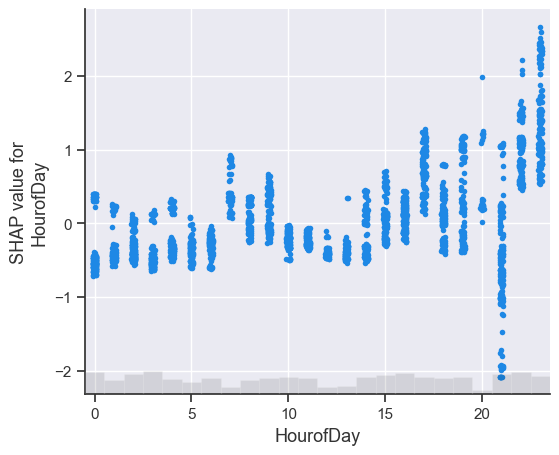

In [64]:
shap.plots.scatter(shap_values[shap_index_job96913.values.tolist(),'HourofDay']) 

Finally the feature importance for a specific job

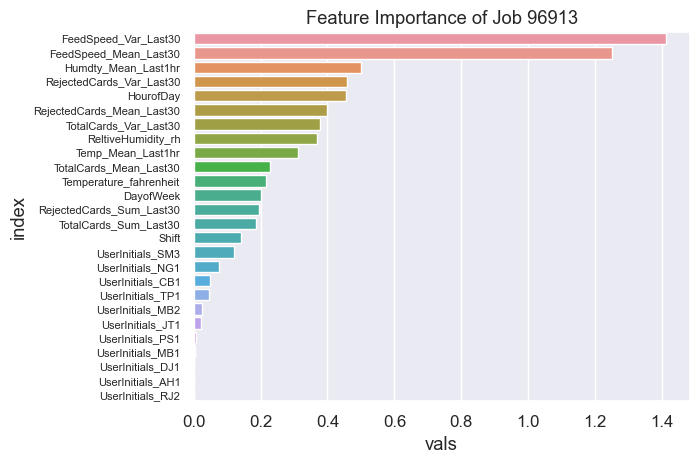

In [66]:
print_feature_importances_shap_values(shap_values[shap_index_job96913.values.tolist()],X_train.columns)
plt.title('Feature Importance of Job 96913')
plt.show()

#### Checking 96662 Job

In [67]:
print(filter_per_Xtrain_2.query('Job==96662').Timestamp.min())
print(filter_per_Xtrain_2.query('Job==96662').Timestamp.max())

2023-05-01 08:34:31
2023-05-05 23:58:26


In [68]:
indexes_job96662 = filter_per_Xtrain[(filter_per_Xtrain.Timestamp>=pd.Timestamp('2023-05-01 08:34:31')) & \
                  (filter_per_Xtrain.Timestamp<=pd.Timestamp('2023-05-05 23:58:26'))].index

shap_index_job96662 = X_train_copy.loc[indexes_job96662].array_idx

If we compare the both plots we can see that more or less both the jobs has similar feature importance. We can go little more deep and see if any specific feature impacted the job or not for other individual jobs

Text(0.5, 1.0, 'Feature Importance of Job 96662')

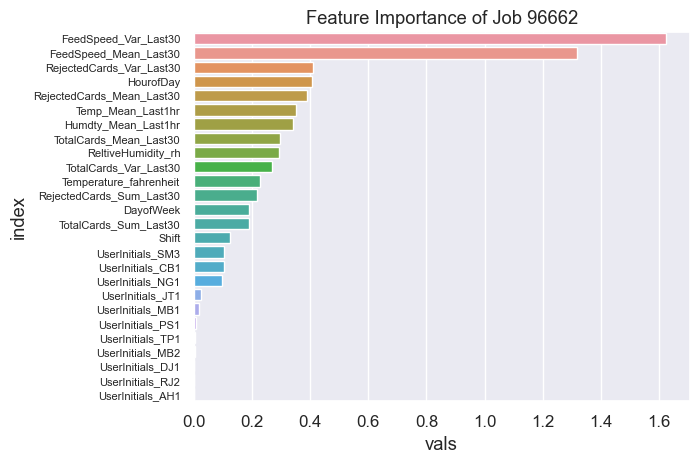

In [93]:
print_feature_importances_shap_values(shap_values[shap_index_job96662.values.tolist()],X_train.columns)
plt.title('Feature Importance of Job 96662')